# NLP Architect - Intent Extraction tutorial

Let's start by importing all the important classes

In [ ]:
import numpy as np
from nlp_architect.models.intent_extraction import MultiTaskIntentModel
from nlp_architect.data.intent_datasets import SNIPS
from nlp_architect.utils.embedding import load_word_embeddings
from nlp_architect.utils.metrics import get_conll_scores

---
## Preparing the data
The first step is the download the dataset into a folder and load the data into the memory
using the `SNIPS` data loader.

### SNIPS NLU Benchmark dataset

SNIPS dataset has 7 types of intents:
- ‘Add to playlist’
- ‘Rate book’
- ‘Check weather’
- ‘Play music’
- ‘Book restaurant’
- ‘Search event’
- ‘Search art’

73 types of labels (including `B-` and `I-` prefixed labels), train/test set sizes: ~14000/700

More info: [here](https://github.com/snipsco/nlu-benchmark)

(The terms and conditions of the data set license apply. Intel does not grant any rights to the data files)

Git clone the repository with the dataset:
```
git clone https://github.com/snipsco/nlu-benchmark.git
```

Point the source of the dataset to `nlu-benchmark/2017-06-custom-intent-engines/` 

In [ ]:
sentence_length = 50
word_length = 12

In [ ]:
dataset_path = 'nlu-benchmark/2017-06-custom-intent-engines/'
dataset = SNIPS(path=dataset_path,
                sentence_length=sentence_length,
                word_length=word_length)

Once the dataset is loaded, we can extract the ready made `train` and `test` sets. Each set is made up of a tuple of 4 elements:
- Words (`train_x` and `test_x`)
- Word character representation (`train_c` and `test_c`)
- Intent type (`train_i` and `test_i`)
- Token slot tags (`train_y` and `test_y`)

In [ ]:
train_x, train_c, train_i, train_y = dataset.train_set
test_x, test_c, test_i, test_y = dataset.test_set

In [ ]:
train_x.shape, train_c.shape, train_i.shape, train_y.shape

Sentences are encoded in sparse int representation (str->int vocabularies stored in the dataset object) as NumPy arrary.
Lets look at the sentence in index 5544, translate it back to strings so we could read the sentence, and look at the encoded label tags.

In [ ]:
train_x[5544]

In [ ]:
rev_vocab = {v:k for k, v in dataset.tokens_vocab.items()}
words = []
for i in train_x[5544]:
    if i > 0:
        words.append(rev_vocab.get(i))
', '.join(words)

In [ ]:
print(train_y[5544].shape)
print(train_y[5544].argmax(1))
rev_vocab = {v:k for k, v in dataset.labels_vocab.items()}
labels = []
for i in train_y[5544].argmax(1):
    if i > 0:
        labels.append(rev_vocab.get(i))
', '.join(labels)

---
### External word embedding

Now it's time to load the external word embedding model.
We'll use `load_word_embeddings` function that reads the file and loads up the words into numpy arrays.
Once done, we'll create a 2D array with the words we have in our dataset word lexicon - we'll save it in `embedding_matrix` and we'll use it later when we load the embedding layer of the words.

You can download the GloVe word embedding models from [here](https://nlp.stanford.edu/projects/glove/).

(The terms and conditions of the data set license apply. Intel does not grant any rights to the data files)


In [ ]:
embedding_path = 'glove.6B.100d.txt'
embedding_size = 100

external_emb, emb_size = load_word_embeddings(embedding_path)
embedding_matrix = np.zeros((dataset.vocab_size, emb_size))
for word, i in dataset.tokens_vocab.items():
    embedding_vector = external_emb.get(word.lower())
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

In [ ]:
embedding_path = '/Users/pizsak/Peter/Datasets/embeddings/glove.6B/glove.6B.100d.txt'
embedding_size = 100

external_emb, emb_size = load_word_embeddings(embedding_path)
embedding_matrix = np.zeros((dataset.vocab_size, emb_size))
for word, i in dataset.tokens_vocab.items():
    embedding_vector = external_emb.get(word.lower())
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

---
## Building the network

Now for the fun part, let's start by defining the parameters of the network we're going to build, such as, the LSTM layer's hidden state, the number of output labels and intents to predict and the size of the character embedding vectors.

The network topology looks as the following diagram

### High level topology

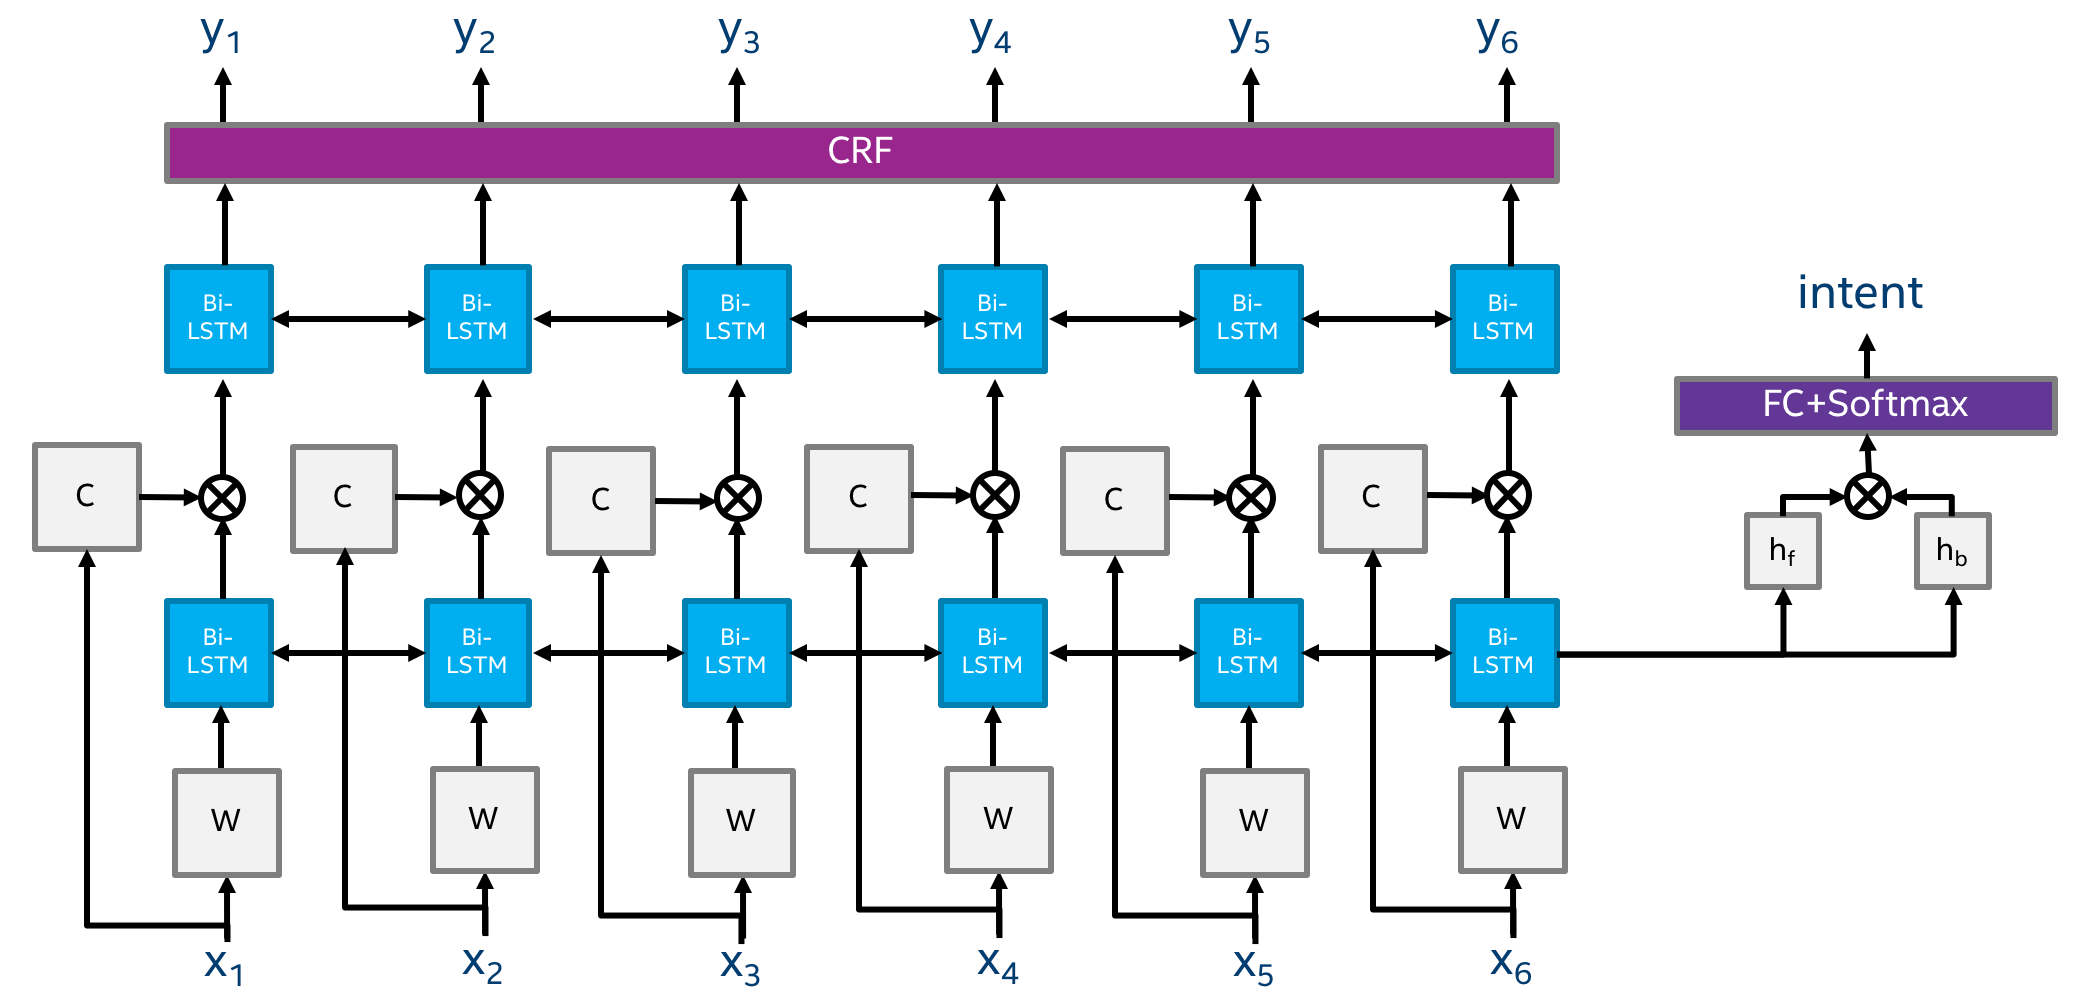

This network is defined in `nlp_architect.models.intent_extraction` packages as `MultiTaskIntentModel`.

In [ ]:
word_vocabulary_size = dataset.vocab_size
character_vocab_size = dataset.char_vocab_size
character_emb_size = 25
char_lstm_hidden_dims = 25
intent_labels = dataset.intent_size
tagging_lstm_hidden_dims = 100
tag_labels = dataset.label_vocab_size

We initiate the model object and build the network with the defined parameters

In [ ]:
model = MultiTaskIntentModel()
model.build(sentence_length,
            word_length,
            tag_labels,
            intent_labels,
            word_vocabulary_size,
            character_vocab_size,
            word_emb_dims=embedding_size,
            char_emb_dims=25,
            char_lstm_dims=25,
            tagger_lstm_dims=100,
            dropout=0.2,
            embedding_matrix=embedding_matrix)

## Training the network
We've got a model, it's time to train the network.

We define the batch size and the number of epochs to run.

In [ ]:
batch_size = 64
no_epochs = 1

# train the model
model.fit([train_x, train_c], [train_i, train_y],
          batch_size=batch_size,
          epochs=no_epochs,
          validation=([test_x, test_c], [test_i, test_y]))

## Testing and evaluating the network
Great! we have a trained model, let's check how well it performs.

First, we need to run all the test data through the network and get the network's preditions. Once done, we can use `get_conll_scores` to get the actual CONLLEVAL benchmark results on the test data (in terms of precision/recall/F1 and per label type).

In [ ]:
predictions = model.predict([test_x, test_c], batch_size=batch_size)

In [ ]:
predictions[0].shape, predictions[1].shape

In [ ]:
eval = get_conll_scores(predictions, test_y,
                        {v: k for k, v in dataset.labels_vocab.items()})

Overall performance

In [ ]:
print('Precision {}'.format(eval[0][0]))
print('Recall {}'.format(eval[0][1]))
print('F1 {}'.format(eval[0][2]))

Per label performance breakdown

In [ ]:
eval[1]

Intent classification accuracy

In [ ]:
from sklearn.metrics import accuracy_score
predicted_intents = predictions[0].argmax(1)
truth_intents = test_i.argmax(1)
accuracy_score(truth_intents, predicted_intents)

Using GloVe 300 word embedding model and 50+ epochs of training should produce a model with:

- Intent detection: >99 F1
- Slot label classification: >95 F1
---